## RL and Advanced DL: Домашнее задание 1

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import gym
env = gym.make('Blackjack-v1')

### Part1

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
EXELENT_NUMBERS = [19, 20, 21]
average_reward = 0
N = 100000
for i in trange(N):
    (player_score, dealer_card, usable_ace), _ = env.reset()
    done = False
    while not done:
        if player_score in EXELENT_NUMBERS:
            (player_score, dealer_card, usable_ace), reward, done, _, _ = env.step(0)
        else:
            (player_score, dealer_card, usable_ace), reward, done, _, _ = env.step(1)
    average_reward += reward
average_reward /= N

100%|████████████████████████████████| 100000/100000 [00:09<00:00, 10695.57it/s]


In [3]:
print(average_reward)

-0.19665


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [4]:
EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 40
NUM_ACTIONS = 2
Q_values = np.array([[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)])
Returns = [[[] for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]

In [5]:
testing_avg_reward = []

# Monte Carlo control
for i in trange(100000):
    
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / 100000
    # generate episode
    episode = []
    (player_score, dealer_card, usable_ace), _ = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
        episode.append((player_score, action, reward, done))
        player_score = player_score_next
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done in episode[::-1]:
        G = reward + G
        Returns[player_score][action] += [G]
        
        Q_values[player_score, action] = np.mean(Returns[player_score][action])
    
    
    # testing model  every 1000 iterations
    if i % 1000 == 0:
        average_reward = 0
        for i in range(N):
            (player_score, dealer_card, usable_ace), _ = env.reset()
            done = False
            while not done:
                if random.uniform(0, 1) > EPSILON:
                    action = np.argmax(Q_values[player_score])
                else:
                    action = random.randint(0, 1)
                (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
                player_score = player_score_next
            average_reward += reward
        testing_avg_reward.append(average_reward / N)
    

100%|██████████████████████████████████| 100000/100000 [13:58<00:00, 119.30it/s]


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

**Основной гиперпараметр EPSILON**. Гамма не влияет, а количество итераций берем большое (на каждое состояние от 4 до 22 много состояний при N > 100000).

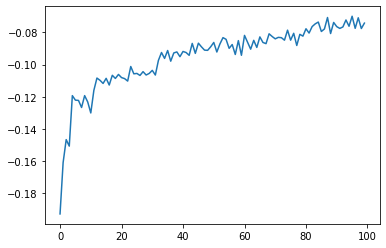

In [6]:
# Средняя награда по итерациям (*1000)
plt.plot(testing_avg_reward)

In [7]:
testing_avg_reward[-1]

-0.07423

In [8]:
average_reward = 0
for i in range(N):
    (player_score, dealer_card, usable_ace), _ = env.reset()
    done = False
    while not done:
        action = np.argmax(Q_values[player_score])
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
        player_score = player_score_next
    average_reward += reward
print(average_reward / N)

-0.06963


### Part2

In [13]:
class BlackJackWithDouble:
    def __init__(self, env):
        self.env = env
    def reset(self):
        return self.env.reset()
    def step(self, action):
        if action == 2:
            (state, d_state, ace), r, done, info1, info2 =  self.env.step(1)
            while not done:
                (state, d_state, ace), r, done, info1, info2 =  self.env.step(0)
            return (state, d_state, ace), 2 * r, done, info1, info2
        return self.env.step(action)

In [14]:
new_env = BlackJackWithDouble(env)

In [15]:
EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 40
NUM_ACTIONS = 3
Q_values = np.array([[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)])
Returns = [[[] for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]

In [17]:
testing_avg_reward = []

# Monte Carlo control
for i in trange(100000):
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / 100000
    # generate episode
    episode = []
    (player_score, dealer_card, usable_ace), _ = new_env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 2)
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = new_env.step(action)
        episode.append((player_score, action, reward, done))
        player_score = player_score_next
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done in episode[::-1]:
        G = reward + G
        Returns[player_score][action] += [G]
        
        Q_values[player_score, action] = np.mean(Returns[player_score][action])


    # testing model  every 5 iterations
    if i % 1000 == 0:
        average_reward = 0
        for i in range(N):
            (player_score, dealer_card, usable_ace), _ = new_env.reset()
            done = False
            while not done:
                if random.uniform(0, 1) > EPSILON:
                    action = np.argmax(Q_values[player_score])
                else:
                    action = random.randint(0, 1)
                (player_score_next, dealer_card, usable_ace), reward, done, _, _ = new_env.step(action)
                player_score = player_score_next
            average_reward += reward
        testing_avg_reward.append(average_reward / N)

100%|██████████████████████████████████| 100000/100000 [13:21<00:00, 124.74it/s]


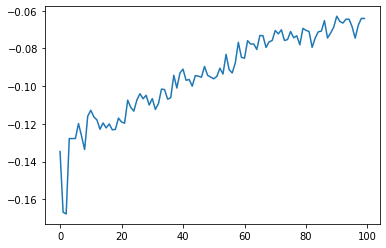

In [18]:
# Средняя награда по итерациям (*1000)
plt.plot(testing_avg_reward)

In [19]:
average_reward = 0
for i in trange(N):
    (player_score, dealer_card, usable_ace), _ = new_env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = new_env.step(action)
        player_score = player_score_next
    average_reward += reward

100%|█████████████████████████████████| 100000/100000 [00:10<00:00, 9355.04it/s]


In [20]:
average_reward / N

-0.0665

### Part3

### Part4